In [2]:
# import importlib
# importlib.reload(data)

import os, sys
from data import DatasetFromFolder, RGBDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from model import *
from torch.utils.tensorboard import SummaryWriter
from math import log10
from PIL import Image
import math

UPSCALE_FACTOR = 3
NUM_EPOCHS = 50

NameError: name 'data' is not defined

## dataset

In [2]:
current_path, filename = os.path.split('.')
current_path = current_path.replace('\\', '/')
image_dir = os.path.join(current_path, '../../data/')

voc_dir = image_dir + '/VOC2012/X' + str(UPSCALE_FACTOR)
set5_test_dir = image_dir + '/Set5/X' + str(UPSCALE_FACTOR)
set14_test_dir = image_dir + '/Set14/X' + str(UPSCALE_FACTOR)

# ------------------- 数据集 --------------------------------------------
train_set = DatasetFromFolder(voc_dir + '/train', upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
val_set = DatasetFromFolder(voc_dir + '/val', upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set5_test_set = DatasetFromFolder(set5_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set14_test_set = DatasetFromFolder(set14_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=64, shuffle=False)
set5_test_loader = DataLoader(dataset=set5_test_set, batch_size=1, shuffle=False)
set14_test_loader = DataLoader(dataset=set14_test_set, batch_size=1, shuffle=False)
print(f'train_loader len: {len(train_loader)}')
print(f'val_loader len: {len(val_loader)}')
print(f'set5_test_loader len: {len(set5_test_loader)}')
print(f'set14_test_loader len: {len(set14_test_loader)}')

train_loader len: 261
val_loader len: 7
set5_test_loader len: 5
set14_test_loader len: 14


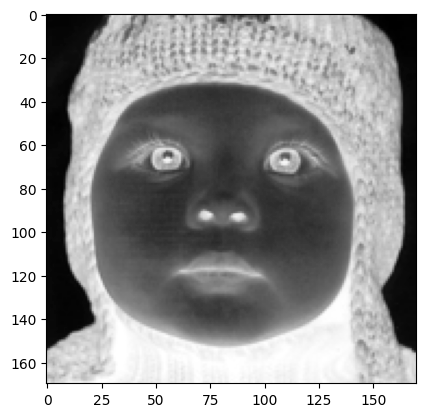

In [3]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    nping = img.numpy()
    if one_channel:
        plt.imshow(nping, cmap='Greys')
    else:
        plt.imshow(np.transpose(nping, (1, 2, 0)))

img, target = set5_test_set[0]
matplotlib_imshow(img, one_channel=True)

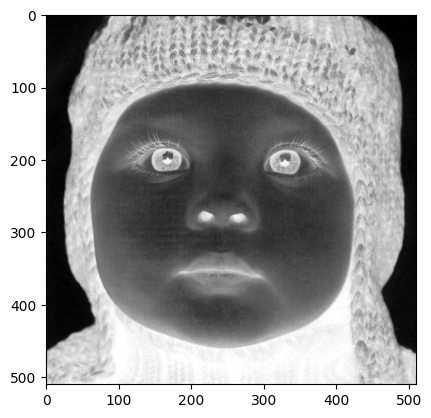

In [4]:
matplotlib_imshow(target, one_channel=True)

## model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)  # 设置PyTorch中所有随机数生成器的种子为0
torch.cuda.manual_seed(0) # 设置使用CUDA时的随机数生成器的种子为0

print(device)

cuda


In [6]:
loss_fn = nn.MSELoss()

learning_rate = [0.001, 0.0001]

In [7]:
for lr in learning_rate:
    models = {'ESPCNModel_tanh': ESPCNModel_tanh(UPSCALE_FACTOR),
          'ESPCNModel_relu': ESPCNModel_relu(UPSCALE_FACTOR)}
    for tag, model in models.items():
        train_step = 0
        val_step = 0
        
        detail = tag  + '_' + str(NUM_EPOCHS) + '_' + str(lr)
        
        # Initialize network
        model = model.to(device)
        # 优化器
        optimizer = optim.Adam(model.parameters(), lr)
        
        # 写入tensorboard中、
        writer = SummaryWriter(f'runs/ESPCNN/{detail}')
        # Visualize model in TensorBoard
        images, _ = next(iter(train_loader))
        writer.add_graph(model, images.to(device))
        writer.close()
        
        for epoch in range(NUM_EPOCHS):  
            model.train()
            for index, (X, y) in enumerate(train_loader):
                # get data to cuda if possible
                X = X.to(device)
                y = y.to(device)
                
                # forward
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                
                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                writer.add_scalar('Training loss', loss, 
                                  global_step=train_step)
                train_step += 1
        
            model.eval()
            with torch.no_grad():
                for X, y in val_loader:
                    X = X.to(device)
                    y = y.to(device)
                    
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    psnr = 10 * log10(1 / loss.item())
                    writer.add_scalar('Val loss',loss, global_step=val_step)
                    writer.add_scalar('Val psnr',psnr, global_step=val_step)
                    val_step += 1
                    
            losses = []
            psnrs = []
            # Set5 test
            with torch.no_grad():
                for X, y in set5_test_loader:
                    X = X.to(device)
                    y = y.to(device)
                    
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    psnr = 10 * log10(1 / loss.item())
                    losses.append(loss.item())
                    psnrs.append(psnr)
            
                writer.add_scalar('Set5 loss',sum(losses)/len(losses), 
                                  global_step=epoch)
                writer.add_scalar('Set5 psnr',sum(psnrs)/len(psnrs), 
                                  global_step=epoch)
            
            losses = []
            psnrs = []
            # Set14 test
            with torch.no_grad():
                for X, y in set14_test_loader:
                    X = X.to(device)
                    y = y.to(device)
                    
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    psnr = 10 * log10(1 / loss.item())
                    losses.append(loss.item())
                    psnrs.append(psnr)
            
                writer.add_scalar('Set14 loss',sum(losses)/len(losses), 
                                  global_step=epoch)
                writer.add_scalar('Set14 psnr',sum(psnrs)/len(psnrs), 
                                  global_step=epoch)
        
        torch.save(model, f'{detail}.pth')
        writer.flush()
            

## visualing resluts

target shape : torch.Size([1, 480, 498])


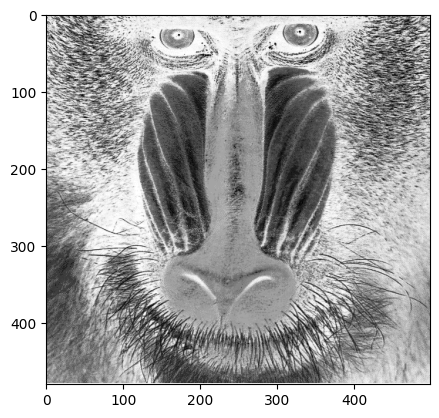

In [8]:
set5_rgb_test_set = RGBDataset(set5_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set14_rgb_test_set = RGBDataset(set14_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

set5_rgb_test_loader = DataLoader(dataset=set5_rgb_test_set, batch_size=1, shuffle=False)
set14_rgb_test_loader = DataLoader(dataset=set14_rgb_test_set, batch_size=1, shuffle=False)

img, target, _, _, _, _ = set14_rgb_test_set[0]
print(f'target shape : {target.shape}')
matplotlib_imshow(target, one_channel=True)

In [9]:
def ycbcr2rgb(tag, y, cb, cr):
    out_img_y = y.numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
    out_img.save(f'{tag}.jpg')

In [10]:
tag = 'ESPCNModel_tanh_50_0.001'
model = torch.load(f'{tag}.pth')
model = model.to(device)

writer = SummaryWriter(f'runs/ESPCNN/{tag}')

# Set5 test
fig = plt.figure(figsize=(15, 9))
count = 1
with torch.no_grad():
    for index, (X, y, in_cb, in_cr, ta_cb, ta_cr) in enumerate(set5_rgb_test_set):
    # for index, (X, y) in enumerate(set5_test_loader):
        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(X, one_channel=True)
        ax.set_title('input')
        count += 1

        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(y, one_channel=True)
        ax.set_title('target')
        count += 1

        X = X.unsqueeze(0)
        y = y.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_pred = model(X)
        print(y_pred.shape)
        loss = loss_fn(y_pred, y)
        psnr = 10 * log10(1 / loss.item())
        
        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(y_pred.cpu().squeeze(0), one_channel=True)
        ax.set_title(f'output loss:{loss.item() * 100:.2f}% psnr:{psnr:.2f}')
        count += 1
        
        X = X.to('cpu').squeeze(0)
        y = y.to('cpu').squeeze(0)
        y_pred = y_pred.to('cpu').squeeze(0)
        ycbcr2rgb(f'./Set5/{index}_input', X, in_cb, in_cr)
        ycbcr2rgb(f'./Set5/{index}_target', y, ta_cb, ta_cr)
        ycbcr2rgb(f'./Set5/{index}_output', y_pred, ta_cb, ta_cr)
        
writer.add_figure(f'{tag}_resluts', fig, global_step=0)

torch.Size([1, 1, 510, 510])
torch.Size([1, 1, 288, 288])
torch.Size([1, 1, 255, 255])
torch.Size([1, 1, 279, 279])
torch.Size([1, 1, 342, 228])


## visualizing feature maps

In [11]:
model = model.to('cpu')
model_children = list(model.children())

img, target = next(iter(set5_test_loader))

results = [model_children[0](img)]
for i in range(1, len(model_children)):
    # tmp = model_children[i](results[-1])
    if type(model_children[i]) == nn.Conv2d  \
            or type(model_children[i]) == nn.PixelShuffle:
        tmp = model_children[i](results[-1])
        results.append(tmp)

outputs = results

In [12]:
for num_layer in range(len(outputs)):
    print(f'each outputs shape: {outputs[num_layer].shape}')
    _, number, _, _ = tuple(outputs[num_layer].shape)
    number = int(math.ceil(math.sqrt(number)))
    
    fig = plt.figure()
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.detach()
    for i, filter in enumerate(layer_viz):
        plt.subplot(number, number, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis('off')
    writer.add_figure(f'{tag}_features_map', fig, global_step=num_layer)
writer.flush()
    # plt.show()

each outputs shape: torch.Size([1, 64, 170, 170])
each outputs shape: torch.Size([1, 32, 170, 170])
each outputs shape: torch.Size([1, 9, 170, 170])
each outputs shape: torch.Size([1, 1, 510, 510])


## visualizing filters

In [13]:

for i in range(0, len(model_children)):
    print(model_children[i])
    if type(model_children[i]) == nn.Conv2d:
        print(f'each filters weights: {model_children[i].weight.shape}')
        
for i in range(0, len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        fig = plt.figure()
        for index, filter in enumerate(model_children[i].weight):
            # print(f'each filters weights: {filter.shape}')
            plt.subplot(8, 8, index+1)
            plt.imshow(filter[0, :, :].detach(), cmap='gray')
            plt.axis('off')
        # plt.show()
        print(i)
        writer.add_figure(f'{tag}_filters', fig, global_step=i)
writer.flush()
        
        

Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
each filters weights: torch.Size([64, 1, 5, 5])
Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
each filters weights: torch.Size([32, 64, 3, 3])
Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
each filters weights: torch.Size([9, 32, 3, 3])
PixelShuffle(upscale_factor=3)
0
1
2
